In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import select
from skimage import feature as ft
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import sys
from sklearn import mixture

importpath   = "../../../Dataset/"
testrainpath = ["Testing", "Training"]
namespath    = ["/Abed/", "/Daniel/", "/Jules/", "/Lea/", "/Patrick/"]
rescaledpath = "Rescaled"
croppedpath  = "Cropped"

meta_data = {0: 'Abed', 1: 'Daniel', 2: 'Jules', 3: 'Lea', 4: 'Patrick'}

def get_data(isCropped=True):

    # Test train data
    X_train = []
    Y_train = []

    X_test  = []
    Y_test  = []

    # define both import paths
    testpath = importpath+testrainpath[0]
    trainpath= importpath+testrainpath[1]

    for i, npath in enumerate(namespath):

        if isCropped:
            testfolder = testpath + croppedpath + npath
            trainfolder= trainpath+ croppedpath + npath
        else:
            testfolder = testpath + rescaledpath + npath
            trainfolder= trainpath+ rescaledpath + npath

        for imgname in os.listdir(testfolder):

            img = cv2.imread(testfolder+imgname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_test.append(img)
            Y_test.append(i)

        for imgname2 in os.listdir(trainfolder):

            img = cv2.imread(trainfolder+imgname2)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_train.append(img)
            Y_train.append(i)

#     # once the data is saved, shuffle it
#     X_train , Y_train = shuffle(X_train, Y_train)
#     X_test  , Y_test  = shuffle(X_test, Y_test)

    return np.asarray(X_train), np.asarray(Y_train), np.asarray(X_test), np.asarray(Y_test), meta_data


In [2]:
def sift(img):

    # copy image
    img_disp = img.copy()
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)
    
    p = []
    keypoints3, descriptors = sift.compute(img, keypoints)
    for k in keypoints3:
        p.append(k.pt)

    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    '''
# #     display
      plt.figure(figsize=(10, 10))
      plt.subplot(121), plt.imshow(img)
      plt.title("Input Image"), plt.xticks([]), plt.yticks([])
      plt.subplot(122), plt.imshow(img_disp)
      plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
      plt.show()

#     # num of SIFT keypoints
      print('Num keypoints: ' + str(len(keypoints)))
    '''

    return p


# Get croppped image coordinates in original image (x,y in top left corner)
def get_coordinates(img_rescaled, img_cropped):
    # imgggg_rgb = cv2.imread("../../../Dataset/TrainingRescaled/Abed/scale1_0.jpeg")
    # img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    # template = cv2.imread("../../../Dataset/TrainingCropped/Abed/scale1_0.jpeg", 0)
    img_rescaled = cv2.cvtColor(img_rescaled, cv2.COLOR_BGR2GRAY)
    img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    w, h = img_cropped.shape[::-1]
    res = cv2.matchTemplate(img_rescaled, img_cropped, cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    x = top_left[0]
    y = top_left[1]
    return x, y


def make_patch(img,img_cropped, size, k):
    # get patch centers
    patch_centers = []
    for i in k:
        patch_centers.append(i)

    # extract patches
    patch_images = []
    patch_size = size
    count=0
    for center in patch_centers:
        patchXStart = int(center[0] - (patch_size / 2.))
        patchYStart = int(center[1] - (patch_size / 2.))
        if((center[0] + patch_size)>img_cropped.shape[1] or (center[0] - patch_size)<0 or (center[1] + patch_size)>img_cropped.shape[0] or (center[1] - patch_size)<0 ):
            count+=1
            x,y = get_coordinates(img, img_cropped)
            patchXStart += x
            patchYStart += y
            patch_images.append(img[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])
        else:
            patch_images.append(img_cropped[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])

    '''
     print("count= " , count)
     # display
     for im in patch_images:
         plt.figure(figsize=(5, 5))
         plt.imshow(im, cmap='gray')
         plt.title("Input Image"), plt.xticks([]), plt.yticks([])
         plt.show()
    '''

    return patch_images


# ----- HoG Function ----- #
def rgb2gray(im):
    gray = im[:, :, 0] * 0.2989 + im[:, :, 1] * 0.5870 + im[:, :, 2] * 0.1140
    return gray

def hog_features(imgs, cells):
    train_x = []
    for data in imgs:
        gray = rgb2gray(data) / 255.0
        x = ft.hog(gray, orientations=9, pixels_per_cell=(2, 2),
                   cells_per_block=(cells, cells), feature_vector=True)
        train_x.append(x)
    return train_x

def get_hog(patches, cell_size):
    hog_patches = []
    for patch in patches:
        hog_ft = hog_features(patch, cell_size)
        hog_patches.append(hog_ft)
    #print(np.array(hog_patches).shape)
    return hog_patches

# Read in Data 

In [3]:
# Load Cropped Data

cropped_data = get_data(isCropped=True)
X_train_cropped = cropped_data[0]
Y_train_cropped = cropped_data[1]
X_test_cropped = cropped_data[2]
Y_test_cropped = cropped_data[3]
metadata_cropped = cropped_data[4]

# Load Original Data

data = get_data(isCropped=False)
X_train = data[0]
Y_train = data[1]
X_test = data[2]
Y_test = data[3]
metadata = data[4]

patches_train_list = []
for i in range(0, len(X_train_cropped)):
    cropped_img = X_train_cropped[i]
    original_img = X_train[i]
    kp = sift(cropped_img)
    patches_train = make_patch(img=original_img,img_cropped=cropped_img, size=15, k=kp[:20])
    patches_train_list.append(patches_train)


# Test Images

patches_test_list = []
for i in range(0, len(X_test_cropped)):  
    cropped_img_test = X_test_cropped[i]
    original_img_test = X_test[i]
    kp = sift(cropped_img_test)
    patches_test = make_patch(img=original_img_test,img_cropped=cropped_img_test, size=15, k=kp[:20])
    patches_test_list.append(patches_test)


## 4.3.1 - HoG with varying Cell sizes 

Bag of words w/ Cell Size 3


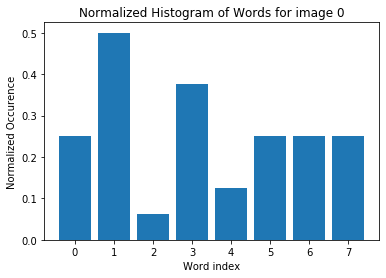

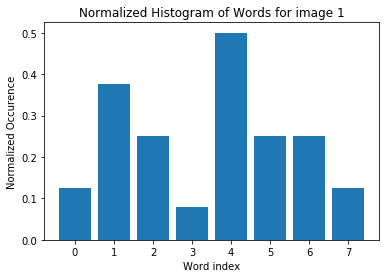

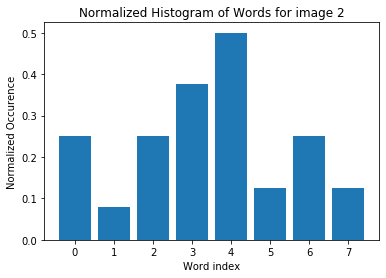

Bag of words w/ Cell Size 4


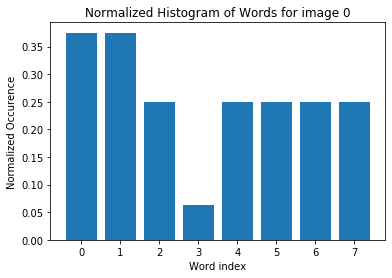

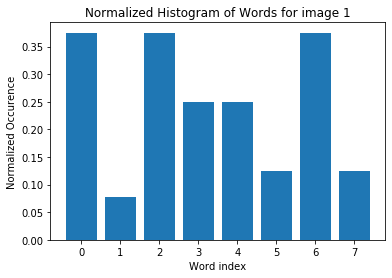

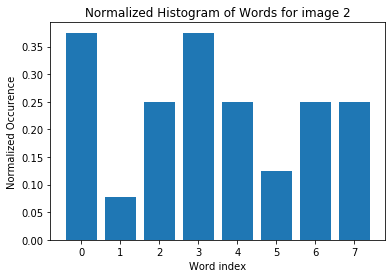

Bag of words w/ Cell Size 5


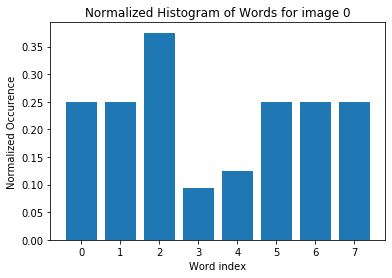

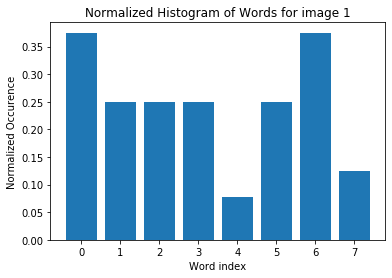

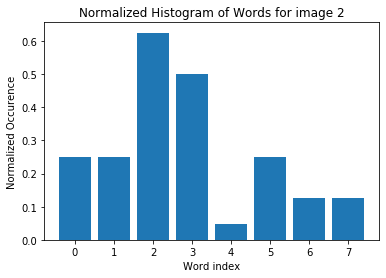

In [4]:
import collections

NUMBER_OF_WORDS = 8
NUMBER_OF_KEYPOINTS = 20

def makeModel(patches, n_words, cov_type='spherical'):
    gmm_ = mixture.GaussianMixture(covariance_type=cov_type, n_components=n_words)
    gmm_.fit(patches)
    #print(np.shape(patches))
    #print('Weight of each cluster', gmm_test.weights_)
    
    # Assign each feature to a group
    predictions = gmm_.predict(patches)
    
    # Get the count of each word
    counts = collections.Counter(predictions)
    
    # Normalize 
    for word in counts:
        counts[word] /= NUMBER_OF_WORDS
        return predictions, counts
    
def closestDistance(bag_of_words_test, bag_of_words_train):
    min_dist = 1e6
    closest_matching = []
    for i in range(len(bag_of_words_test)):
        indx = i
        for j in range(len(bag_of_words_train)):
            temp_dist = np.linalg.norm(bag_of_words_test[i] - bag_of_words_train[j])
            if(temp_dist < min_dist):
                min_dist = temp_dist
                indx = j
        closest_matching.append(Y_train[indx])

    #print(np.shape(closest_matching))
    #print(closest_matching)

    accuracy = np.zeros(2)
    for i in range(len(closest_matching)):
        if(Y_test[i] == closest_matching[i]):
            accuracy[0] += 1
        else:
            accuracy[1] += 1

    #print('Correct', accuracy[0])
    #print('Wrong', accuracy[1])
    #print('Accuracy', accuracy[0]/(accuracy[0]+accuracy[1]))
    
    conf = confusion_matrix(Y_test, closest_matching)
    
    return accuracy, conf

def BagOfWords(h_train, h_test):
    # Make a model to predict each group of features for each train image
    bag_of_words_train = []
    counts_train = []
    for i in range(len(h_train)):
        words, count = makeModel(h_train[i], n_words=NUMBER_OF_WORDS)
        bag_of_words_train.append(words)
        counts_train.append(count)

    #print('Bag of words Shape', np.shape(bag_of_words_train))

    #for i in range(3):
        #print('Word prediction for image '+str(i), bag_of_words_train[i])
        #print('Normalized Word count for image '+str(i), counts_train[i])

    # Display the histograms for 3 training images
    for i in range(3):
        n_words = NUMBER_OF_WORDS
        kp = NUMBER_OF_KEYPOINTS
        plt.xticks(np.arange(kp))
        plt.xlabel('Word index')
        plt.ylabel('Normalized Occurence')
        plt.title('Normalized Histogram of Words for image '+str(i))
        normalized = np.zeros(n_words)
        for i,j in counts_train[i].items():
            normalized[i] = j/n_words
        plt.bar(range(n_words), normalized)
       #plt.bar(n_words, (counts_train[i].items()/n_words))
        plt.show()

    # Make a model to predict each group of features for each test image
    bag_of_words_test = []
    counts_test = []
    for img in h_test:
        words, count = makeModel(h_test[i], n_words=NUMBER_OF_WORDS)
        bag_of_words_test.append(words)
        counts_test.append(count)

    # Find closest matching
    accur = closestDistance(bag_of_words_test, bag_of_words_train)
    
    return accur

h_3_train = np.array(get_hog(patches_train_list, 3))
#print(h_3_train.shape)
h_3_test = get_hog(patches_test_list, 3)

h_4_train = get_hog(patches_train_list, 4)
h_4_test = get_hog(patches_test_list, 4)

h_5_train = get_hog(patches_train_list, 5)
h_5_test = get_hog(patches_test_list, 5)

print('Bag of words w/ Cell Size 3')
acc3, conf3 = BagOfWords(h_3_train, h_3_test)
print('Bag of words w/ Cell Size 4')
acc4, conf4 = BagOfWords(h_4_train, h_4_test)
print('Bag of words w/ Cell Size 5')
acc5, conf5 = BagOfWords(h_5_train, h_5_test)

accuracies = []
accuracies.append(acc3)
accuracies.append(acc4)
accuracies.append(acc5)

confusions = []
confusions.append(conf3)
confusions.append(conf4)
confusions.append(conf5)

Accuracy of Bag of words w/ Cell Size3 80.0%


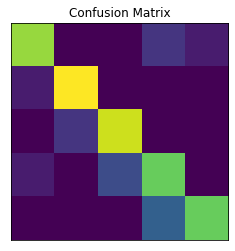

Accuracy of Bag of words w/ Cell Size4 80.0%


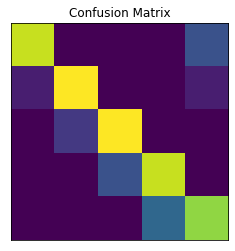

Accuracy of Bag of words w/ Cell Size5 81.42857142857143%


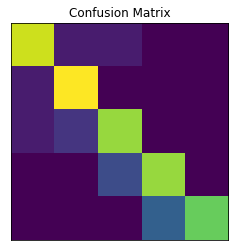

In [5]:
cell_size = [3, 4, 5]
for i in range(len(accuracies)):
    acc = accuracies[i][0] / (accuracies[i][0]+accuracies[i][1])
    print('Accuracy of Bag of words w/ Cell Size' +str(cell_size[i])+' ' +str(acc*100) +'%' )
    plt.figure()
    plt.imshow(confusions[i])
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()

## 4.3.1 - LpB with varying radius sizes 

In [6]:
from skimage import feature

def getLBPFt(img, radius):
    features = []
    count = 0
    for patch in img:
        data = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
        lbp = feature.local_binary_pattern(data, 8*radius, radius, method="uniform")
        features.append(np.array(lbp).ravel())

    return features

def getLBP(images, radius):
    lbp = []
    for img in images:
        l_ft = getLBPFt(img, radius)
        lbp.append(l_ft)
    return lbp

(75, 20, 225)
Bag of words w/ radius 2


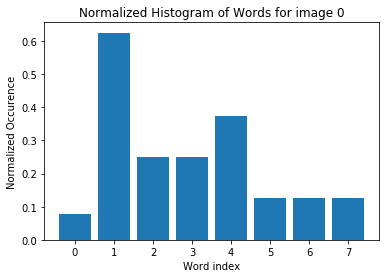

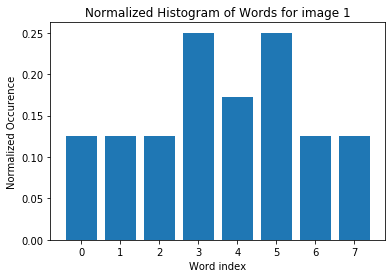

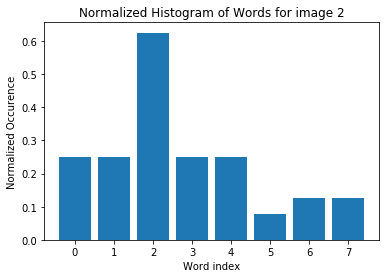

Bag of words w/ radius 7


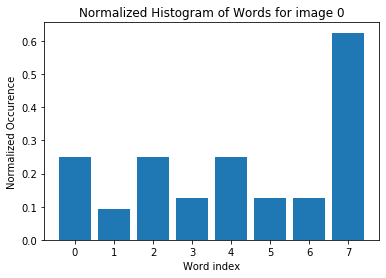

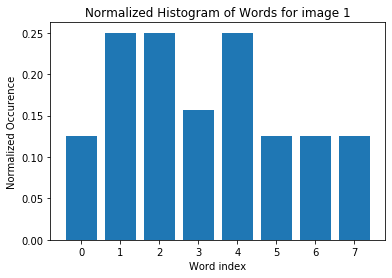

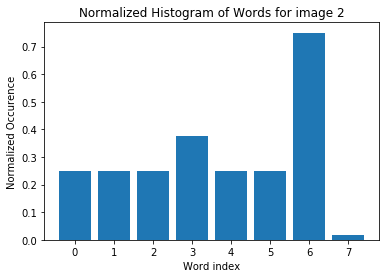

Bag of words w/ radius 12


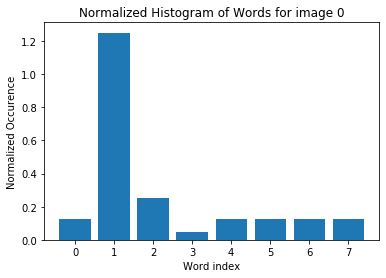

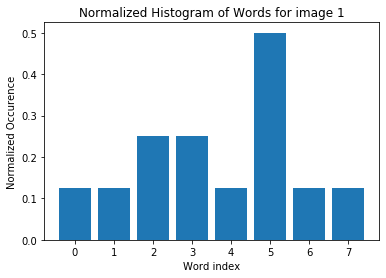

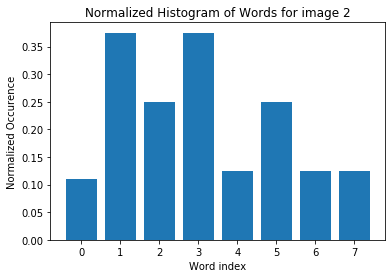

In [7]:
lbp_2_train = getLBP(patches_train_list, 2)
print(np.array(lbp_2_train).shape)
lbp_2_test = getLBP(patches_test_list, 2)

lbp_7_train = getLBP(patches_train_list, 7)
lbp_7_test = getLBP(patches_test_list, 7)

lbp_12_train = getLBP(patches_train_list, 12)
lbp_12_test = getLBP(patches_test_list, 12)

print('Bag of words w/ radius 2')
acc3, conf3 = BagOfWords(lbp_2_train, lbp_2_test)
print('Bag of words w/ radius 7')
acc4, conf4 = BagOfWords(lbp_7_train, lbp_7_test)
print('Bag of words w/ radius 12')
acc5, conf5 = BagOfWords(lbp_12_train, lbp_12_test)

accuracies = []
accuracies.append(acc3)
accuracies.append(acc4)
accuracies.append(acc5)

confusions = []
confusions.append(conf3)
confusions.append(conf4)
confusions.append(conf5)

Bag of words with radius:2, Accuracy: 81.42857142857143%


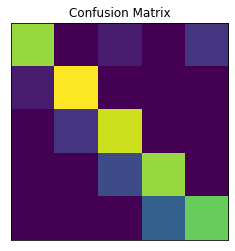

Bag of words with radius:7, Accuracy: 82.85714285714286%


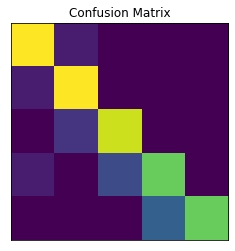

Bag of words with radius:12, Accuracy: 81.42857142857143%


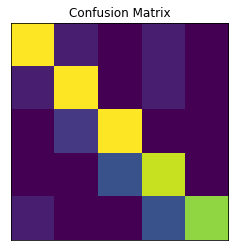

In [8]:
radius_size = [2, 7, 12]
for i in range(len(accuracies)):
    acc = accuracies[i][0] / (accuracies[i][0]+accuracies[i][1])
    print('Bag of words with radius:' +str(radius_size[i])+', Accuracy: ' +str(acc*100) +'%' )
    plt.figure()
    plt.imshow(confusions[i])
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()

## 4.3.2 - Varying Patch sizes 